### Requirements and questions ###

**Exploratory Analysis**
<ul>
<li>Are there any correlation between features? why or why not? </li>
<li>Are there any outliers in the dataset? why or why not? </li>
<li>Are there any normalization needed? why or why not?</li>
<li>Are there any missing values? Why or why not?</li>
</ul>

**Classification**
<ul>
<li>Expriment the following algorithms/models: decision tree, random forest, adaboost, KNN, SVM, MLP, and Naive Baye</li>
<Li>For each model, train-test-split with 80% for training and 20% for testing.</li>
<li>For each algorithm, output the following performance meaures: accuracy, precision, and recall</li>
</ul>

**Visualization**
<ul>
<li>Pick at least one visualization for model perfomance comparison.
</ul>

**Reflection**
<ul>
<li>What is the best K in KNN? Only consider k in the range of 1-15. Use odd numbers only.</li>
<li>What is the most important features found by decision tree and random forest? (optional)</li>
<li>Which algorithm has the highest accuracy? Is there a model overfitting for this algorithm? Why or why not?Perform 10-fold cross-validation with this algorithm and report the accuracy, precision and recall. </li>
</ul>

In [79]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pydotplus

from sklearn import tree, ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle,resample

from IPython.display import Image

In [80]:
# Import Iris Dataset
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
iris = fetch_ucirepo(id=53)
  
# data (as pandas dataframes) 
DataFeatures = iris.data.features 
DataTargets = iris.data.targets

# create Pandas dataframe of merged data, iris is not a DataFrame
iris_merged_df = pd.merge(DataFeatures,DataTargets, right_index=True, left_index=True)

### Exploratory Analysis

Will take a look at the data, pull up statistical analysis and see if there is anything missing or null. Looking at the range of the dataset can determine if normalization is needed. 

In [81]:
iris_merged_df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [82]:
iris_merged_df.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Normalization is not needed as the ranges are relatively the same (between 0 and 8) with means all between 1 and 6.  

In [83]:
print('Number of missing values by column:')
print(iris_merged_df.isna().sum())

print("\nTotal number of missing values = %d" % (iris_merged_df.isna().sum().sum()))

print('\nNumber of instances = %d' % (iris_merged_df.shape[0]))
print('Number of attributes = %d' % (iris_merged_df.shape[1]))

Number of missing values by column:
sepal length    0
sepal width     0
petal length    0
petal width     0
class           0
dtype: int64

Total number of missing values = 0

Number of instances = 150
Number of attributes = 5


There are no null or missing data.  Next, a quick visualization of the data to look at any correlations. 

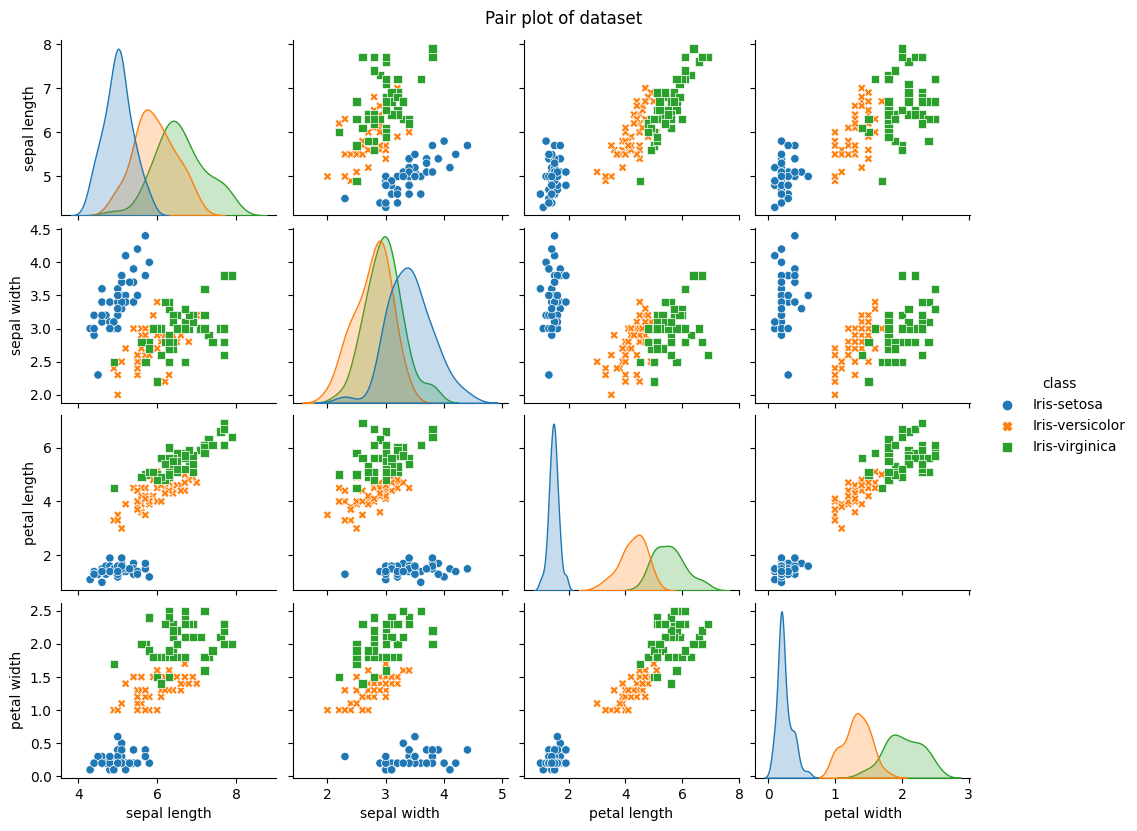

In [84]:
# Visualize entire dataset using Seaborn
# Surpress warnings to free up physical space on printed assignment, source: (https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    g = sns.pairplot(iris_merged_df, hue='class', markers=['o','X','s'])
    g.fig.set_figheight(8)
    g.fig.suptitle('Pair plot of dataset', y=1.02)

In [85]:
correlation_iris_merged_df = iris_merged_df.corr(numeric_only=True)
correlation_iris_merged_df

,sepal length,sepal width,petal length,petal width
sepal length,1.000000,-0.109369,0.871754,0.817954
sepal width,-0.109369,1.000000,-0.420516,-0.356544
petal length,0.871754,-0.420516,1.000000,0.962757
petal width,0.817954,-0.356544,0.962757,1.000000


There is a strong correlation between petal width and petal length with a value of 0.962757.  Petal length and sepal length are slightly correlated at 0.871754.  Other items are not strongly or slightly correlated. Next, it needs to be determined if outliers exist. A boxplot will first be used to visually check.  

<Axes: >

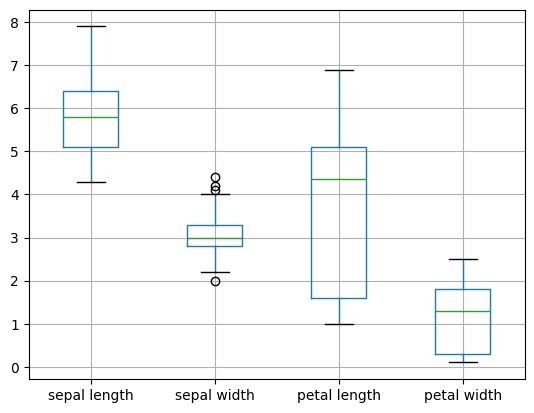

In [86]:
DataFeatures.boxplot()

Boxplot indicates that outliers exist in the sepal width data.  A Z-score can be used to quantify the outlier.  I will use the Z-score and remove the outliers.

In [87]:
Z = (DataFeatures-DataFeatures.mean()) / DataFeatures.std()
Z[(Z.values > 3) | (Z.values < -3)] 

,sepal length,sepal width,petal length,petal width
15,-0.173094,3.104284,-1.280118,-1.046525


There is one value that has a Z score above 3 or below -3, this will be removed. A new pandas dataframe will need to be created with the removed outliers.

In [88]:
print('Number of rows before discarding outliers = %d' % (DataFeatures.shape[0]))
DataFeatures_pp = DataFeatures.drop(15, axis=0)
DataTargets_pp = DataTargets.drop(15, axis=0)
print('Number of rows after discarding missing values = %d' % (DataFeatures_pp.shape[0]))

Number of rows before discarding outliers = 150
Number of rows after discarding missing values = 149


Confirmed that outliers are removed.  

### Classification

##### Decision Tree

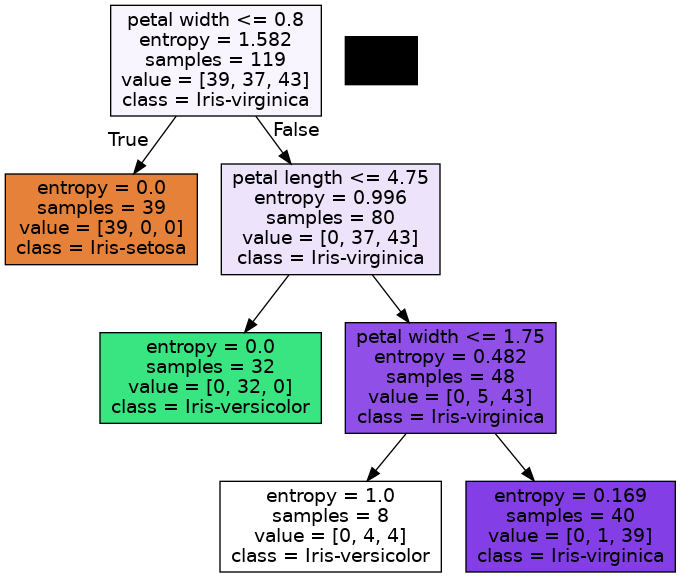

In [89]:
# First create the training and testing data
DataFeatures_train, DataFeatures_test, DataTargets_train, DataTargets_test = train_test_split(DataFeatures_pp,DataTargets_pp, test_size=0.2, train_size=0.8, random_state=1)

# Create decision tree based off of training set
hwt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
hwt = hwt.fit(DataFeatures_train, DataTargets_train)

# Print off decision tree made with training set 
dot_data = tree.export_graphviz(hwt, feature_names=DataFeatures.columns, class_names=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], filled=True, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(graph.create_png()))


In [90]:
# Now lets see how accurate the decision tree is against the test data
predDataTargets = hwt.predict(DataFeatures_test)
print('Accuracy on test data is %.9f' % (accuracy_score(DataTargets_test, predDataTargets)))

Accuracy on test data is 0.966666667


##### Random Forest

In [95]:
numBaseClassifiers = 100
maxdepth = 10
trainAcc = []
testAcc = []

rfc = ensemble.RandomForestClassifier(n_estimators=numBaseClassifiers)
rfc.fit(DataFeatures_train, DataTargets_train)
target_pred_train = rfc.predict(DataFeatures_train)
target_pred_test = rfc.predict(DataFeatures_test)

trainAcc.append(accuracy_score(DataFeatures_train, target_pred_train))
testAcc.append(accuracy_score(DataFeatures_test, DataTargets_test))

/home/raven/Documents/CS/CS522_DM/github/CS522_DataMining/datamining/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

##### adaboost

##### K-Nearest Neighbors

##### Support Vector Machine

##### Multi-Layer Perceptron

##### Naive Baye